## GP example

We are going to provide an easy example to understand all the steps that are necessary to make an accurate prediction using Gaussian processes regression. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
from sklearn.datasets import fetch_mldata

In [2]:
x=np.array([-2.5,-1.50,-0.5,0.75,1.95,2.8])
y=np.array([-0.6,-0.1,0.3,0.45,0.6,0.75])

[-2.5  -1.5  -0.5   0.75  1.95  2.8 ]
[-0.6  -0.1   0.3   0.45  0.6   0.75]


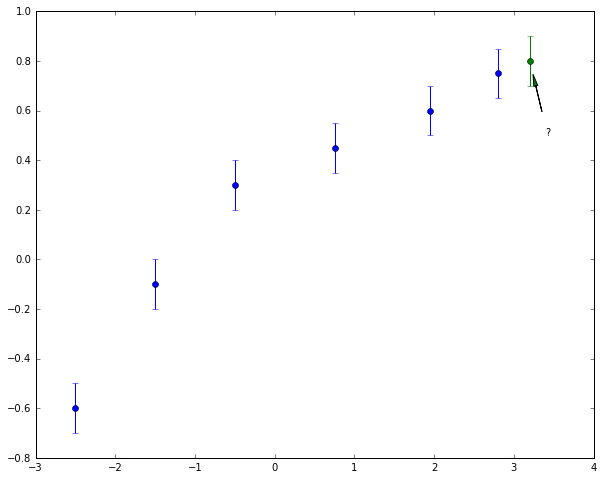

In [54]:
print x
print y
e = 0.1*np.ones(6)
plt.figure(figsize=(10,8))
plt.scatter(x, y)
plt.scatter(3.2,0.8,color='green')
plt.errorbar(x, y, yerr=e, fmt='o')
plt.errorbar(3.2, 0.8, yerr=0.1, fmt='o',color='green')
plt.annotate('?', xy=(3.2, 0.8), xytext=(3.4, 0.5),
            arrowprops=dict(facecolor='green', width=0.1,headwidth=4.0,shrink=0.20),
            )
plt.show()

Given six data points we are interested in estimating a seventh at x∗ = 3.2.

What relates one observation to another in such cases is just the covariance function, k(x, x'). A popular choice is the squared exponential.

In [33]:
# Kernel with parameters randomly initialized 
k1 = 1.0**2 * RBF(length_scale=2.0) + 0.1*WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpml = k1 

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)

In [44]:
def kernelvar(x,x1,variance,lengthscale,sigma):
    val=variance*np.exp(-(x-x1)**2/float(2*lengthscale**2))
    if np.abs(x-x1)<=(1e-4):
        val=val+sigma
    return val

We are going to consider that the noise of our data is σn^{2} = 0.1. With judicious choices of σf and l (more
on this later), we have enough to calculate a covariance matrix using:

In [45]:
K=np.zeros((6,6))
for i in np.arange(x.shape[0]):
    for j in np.arange(x.shape[0]):
        K[i][j]=kernelvar(x[i],x[j],1.5,2.0,0.1)

In [46]:
print K

[[ 1.6         1.32374535  0.90979599  0.40057775  0.12620504  0.04478935]
 [ 1.32374535  1.6         1.32374535  0.79664399  0.3387993   0.14870588]
 [ 0.90979599  1.32374535  1.6         1.23386634  0.70832844  0.38451023]
 [ 0.40057775  0.79664399  1.23386634  1.6         1.25290532  0.8870558 ]
 [ 0.12620504  0.3387993   0.70832844  1.25290532  1.6         1.37046844]
 [ 0.04478935  0.14870588  0.38451023  0.8870558   1.37046844  1.6       ]]


We also have to determine $K^{*}$ and $K^{**}$

In [47]:
Kt=np.zeros(6)
for i in np.arange(x.shape[0]):
    Kt[i]=kernelvar(3.2,x[i],1.5,2.0,0.1)

In [48]:
print Kt

[ 0.02584121  0.09481905  0.27095978  0.70832844  1.23386634  1.47029801]


In [49]:
Ktest=kernelvar(3.2,3.2,1.5,2.0,0.1)
print Ktest

1.6


Our best estimate for $y^{∗}$ is the mean of this distribution:
$$y_{∗}=K^{*}K^{-1}y $$

In [50]:
from numpy.linalg import inv

Kinv=inv(K)
print Kinv
yprev=np.dot(Kt,Kinv)
print yprev
ymean=np.dot(yprev,y)
print ymean

[[ 2.34297674 -2.56023038  0.53037467  0.46721326 -0.22503419 -0.02137222]
 [-2.56023038  5.15942136 -3.16591154  0.22732796  0.52042943 -0.21882785]
 [ 0.53037467 -3.16591154  4.80361281 -2.70692257  0.32171652  0.35017831]
 [ 0.46721326  0.22732796 -2.70692257  4.35452873 -2.84058407  0.63520568]
 [-0.22503419  0.52042943  0.32171652 -2.84058407  5.13572863 -2.94350782]
 [-0.02137222 -0.21882785  0.35017831  0.63520568 -2.94350782  2.73085799]]
[-0.01664828  0.04663839  0.00953405 -0.18636164  0.12760624  0.90679699]
0.680984094323


And the uncertainty in our estimate is captured in its variance:

$$ var(y_{*}) = K^{**}-K^{*}K^{-1}K^{T}_{*} $$

In [51]:
varprev=np.dot(np.dot(Kt,Kinv),np.transpose(Kt))
print varprev
vary=Ktest-varprev
print vary

1.36528094322
0.234719056782


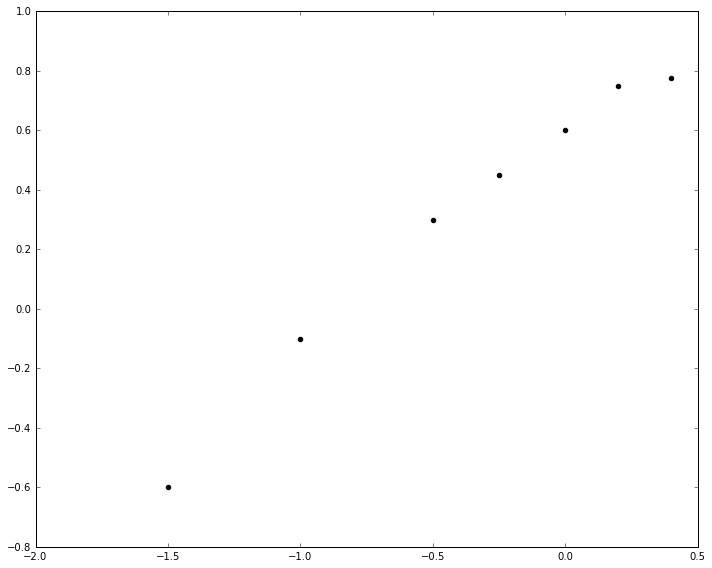

In [185]:
x1=np.append(x,[0.4])
y1=np.append(y,[ymean])
xs=np.array([0.4]).reshape(-1,1)

k1 = 1.5**2 * RBF(length_scale=2.0) + 0.1**2*WhiteKernel(noise_level=0.1**2)
kernel_gpml = k1

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
gp.fit(x.reshape(-1,1),y)
X_ = np.linspace(-2.0, 0.5, 1000)[:, np.newaxis]
X_1=np.append(x,[0.4])[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)
y_pred1,y_std1=gp.predict(X_1, return_std=True)
plt.figure(figsize=(10,8))
plt.scatter(x1, y1, c='k')
#plt.fill_between(X_1[:, 0], y1 - y_std1, y1 + y_std1,
#                 alpha=0.5, color='c')
plt.fill_between(X_[:, 0], y_ - 5*y_std, y_pred + 5*y_std,
#                 alpha=0.5, color='r')
plt.tight_layout()
plt.show()

In [160]:
print y_pred1
print y_std1

[ 0.93378625]
[ 0.01036407]


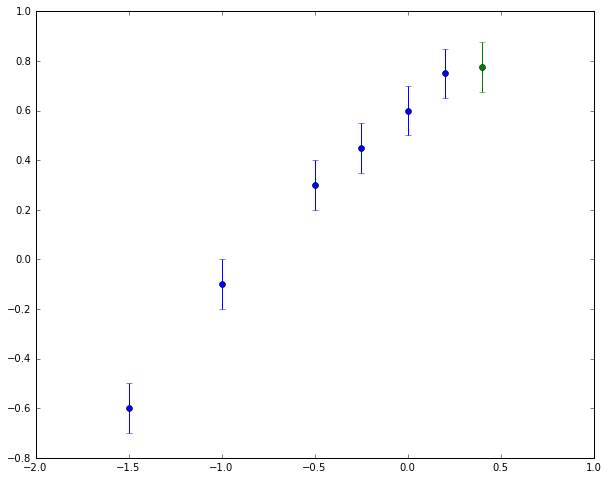

In [142]:
e = 0.1*np.ones(6)
X_ = np.linspace(-2.0, 1.0, 1000)[:, np.newaxis]
plt.figure(figsize=(10,8))
plt.scatter(x, y)
plt.scatter(0.4,ymean,color='green')
plt.errorbar(x, y, yerr=e, fmt='o')
plt.errorbar(0.4, ymean, yerr=0.1, fmt='o',color='green')
plt.fill_between(X_[:,0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.show()